In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Final Project, Heat Diffusion Equation in a Cilinder

The Heat Diffusion Equation is defined in the space $(t, x, y)$ as
$$ u_t = \alpha (u_{xx} + u_{yy}) $$
where $\alpha$ is the termal diffusivity constant. 

## Domain Sampling

In [4]:
# t sampling
N_t = 40
T0, TF = 0, 1

t = np.random.uniform(T0, TF, N_t) # Sampling of the time 

In [5]:
# Transformation to cartesian
def polar(r, theta):
  return np.array([r*np.cos(theta), r*np.sin(theta)]).T

# Normal coordenates in points
def N_circ(R, X): # X is the coordenates vector
    return (1/R)*X/np.sqrt(np.sum(X**2))

# Circle Sampling
def circleSampling(n_int, n_bdy):
    #Radiuos
    R = 1.0
    
    # Boundry points
    theta_bdy = np.random.uniform(0, 2*np.pi, n_bdy)
    X_bdy = polar(R, theta_bdy)

    # Neumann (dx, dy)
    dX_bdy = N_circ(R, X_bdy)

    # Uniform sampling (2D)
    theta_int = np.random.uniform(0, 2*np.pi, n_int)
    r_int = R * np.sqrt(np.random.uniform(0, 1, n_int))
    #Interior points
    X_int = polar(r_int, theta_int)

    return X_bdy, dX_bdy, X_int

In [6]:
# Total sampling in the cilinder
N_int = 40
N_bdy = 10

def condPerCircle(t0, N_int, N_bdy):
    X_bdy, dX_bdy, X_int = circleSampling(N_int, N_bdy)

    # Point in t
    p_bdy = t0*np.ones((N_bdy, 1))
    p_int = t0*np.ones((N_int, 1))

    # Normal in t
    p_n = np.zeros((N_bdy, 1))

    # Appending
    X_n = np.hstack([p_bdy, X_bdy, p_n, dX_bdy])
    X_f = np.hstack([p_int, X_int])

    return X_n, X_f

def concatenation(N_t):
    for idx in range(40):
        if idx == 0: # First inteirior circle
            X_n, X_f = condPerCircle(t[idx], N_int, N_bdy)

        else: # Appending the next
            Next_un, Next_f = condPerCircle(t[idx], N_int, N_bdy)
            # To preserve structure
            X_n = np.vstack([X_n, Next_un])
            X_f = np.vstack([X_f, Next_f])
    return X_n, X_f

In [7]:
X_n, X_f = concatenation(N_t)

### Determinate Neumann conditions values

In [9]:
X_n.shape

(400, 6)

In [10]:
# Condiciones de Dirichlet Nulas
un = np.zeros((X_n.shape[0], 1))

# rhs
A = 5 #Intensidad
s = 0.3 #Varianza

def f(X):
    return np.array([A*np.exp( -(X[:,1]**2 + X[:,2]**2)/(2*s**2) )]).T

rhs = f(X_f)

In [11]:
un.shape, rhs.shape

((400, 1), (1600, 1))

In [12]:
rhs.min(), rhs.max() # Verificar que no cambian mucho, para evitar problemas númericos

(np.float64(0.019467651320648517), np.float64(4.96882626086119))

### The first and las circle; Dirichlet Conditions.

In [14]:
# t boundries
N_border, N_face = 20, 60
N_full = N_border + N_face

# Only Dirichlet Conditions in the border.
X_bdy, _, X_int = circleSampling(N_face, N_border)

# First face
X_u = np.vstack([X_bdy, X_int])
X_u = np.hstack([np.zeros((N_full, 1)), X_u])

# Condition for the first 
u = np.zeros((N_full, 1))

In [15]:
X_u.shape, u.shape, X_n.shape, un.shape, X_f.shape, rhs.shape

((80, 3), (80, 1), (400, 6), (400, 1), (1600, 3), (1600, 1))

### Cloud of points

In [17]:
angle = np.linspace(0,2*np.pi, 200)

Pts = polar(1.0, angle)

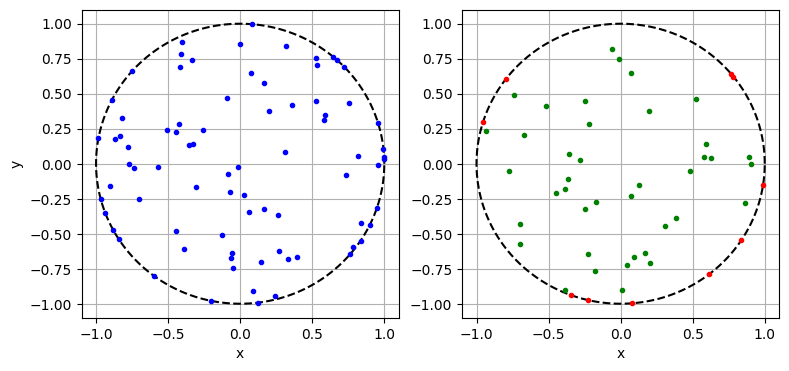

In [18]:
# Graphs for Dirichlet points
fig = plt.figure(figsize = (9,4))

# Dirichlet 1 face
ax1 = fig.add_subplot(121)
ax1.plot(Pts[:,0], Pts[:,1], '--k')
ax1.plot(X_u[:N_full,1], X_u[:N_full,2], '.b', label = 'Dirichlet')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax1.grid(True)

ax3 = fig.add_subplot(122)
ax3.plot(Pts[:,0], Pts[:,1], '--k')
ax3.plot(X_f[:N_int,1], X_f[:N_int,2], '.g', label = 'Interior')
ax3.plot(X_n[:N_bdy,1], X_n[:N_bdy,2], '.r', label = 'Neumann')
ax3.set_xlabel('x')
ax3.grid(True)

# plt.savefig('Sampling2D.png')
plt.show()

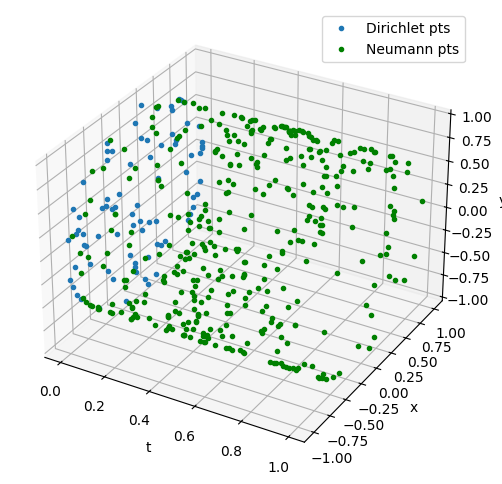

In [19]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')

# Interior points
# ax.plot(X_f[:,0], X_f[:,1], X_f[:,2], '.r', label = 'Interior pts')

# Boundry points
ax.plot(X_u[:,0], X_u[:,1], X_u[:,2], '.', label = 'Dirichlet pts')
ax.plot(X_n[:,0], X_n[:,1], X_n[:,2], '.g', label = 'Neumann pts')

# Style
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('y')

ax.legend()

# plt.savefig('BdySampling.png')
plt.show()

## Solution Implementation

In [21]:
from PINN_3D_HeatDiffusion import PINN_HeatDiffusion # Código implementado

In [22]:
# Learning rate
lr = 1e-3

# Arquitecture
Ne = 40
layers = [3, Ne, Ne, Ne, Ne, Ne, 1]

# Epochs
epochs = 4000

model = PINN_HeatDiffusion(X_u, u, X_n, un, X_f, rhs, layers, epochs, lr)

In [23]:
start_time = time.time()
model.train()
elapsed = time.time() - start_time

Epoch 0, Loss: 2.12149e+00,  U_loss: 6.85248e-02, Un_loss: 5.35946e-03, f_loss: 2.04760e+00
Epoch 100, Loss: 3.12438e-02,  U_loss: 9.33553e-03, Un_loss: 1.02019e-02, f_loss: 1.17064e-02
Epoch 200, Loss: 2.35213e-02,  U_loss: 9.15232e-03, Un_loss: 9.10877e-03, f_loss: 5.26019e-03
Epoch 300, Loss: 1.98044e-02,  U_loss: 7.99058e-03, Un_loss: 7.58499e-03, f_loss: 4.22881e-03
Epoch 400, Loss: 1.68920e-02,  U_loss: 6.94074e-03, Un_loss: 5.96215e-03, f_loss: 3.98910e-03
Epoch 500, Loss: 1.35003e-02,  U_loss: 5.90167e-03, Un_loss: 4.08497e-03, f_loss: 3.51369e-03
Epoch 600, Loss: 1.01133e-02,  U_loss: 4.78472e-03, Un_loss: 2.31074e-03, f_loss: 3.01779e-03
Epoch 700, Loss: 7.31771e-03,  U_loss: 3.65573e-03, Un_loss: 1.05392e-03, f_loss: 2.60806e-03
Epoch 800, Loss: 5.49712e-03,  U_loss: 2.81133e-03, Un_loss: 5.69915e-04, f_loss: 2.11588e-03
Epoch 900, Loss: 4.39676e-03,  U_loss: 2.28532e-03, Un_loss: 5.09120e-04, f_loss: 1.60232e-03
Epoch 1000, Loss: 3.76126e-03,  U_loss: 1.97036e-03, Un_loss: 

In [24]:
print(f'El tiempo de entrenamiento fue de {elapsed:.4f} segundos')

El tiempo de entrenamiento fue de 64.7161 segundos


## Error Learning Analysis

In [26]:
loss_history, u_loss, un_loss, f_loss = model.history()

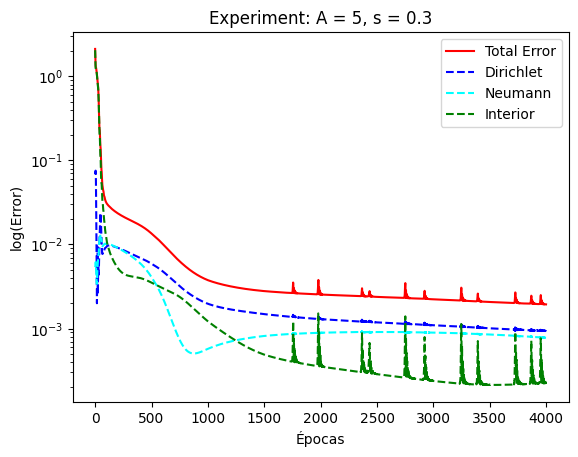

In [136]:
# Epochs vs log(Error) 
plt.semilogy(range(epochs), loss_history, '-', color = 'red', label = 'Total Error')
plt.semilogy(range(epochs), u_loss, '--', color = 'blue', label = 'Dirichlet')
plt.semilogy(range(epochs), un_loss, '--', color = 'cyan', label = 'Neumann')
plt.semilogy(range(epochs), f_loss, '--', color = 'green', label = 'Interior')

# Markers
midpoint = 3500
"""
plt.text(
    midpoint,       # Centro en X
    0.9,            # Altura del texto
    "Change",
    transform=plt.gca().get_xaxis_transform(),
    rotation=90,
    ha='center',
    va='top',
    bbox=dict(alpha=0.7)
)

plt.axvspan(midpoint-500, midpoint+500, alpha=0.2) # Highlite region
"""
plt.xlabel('Épocas')
plt.ylabel('log(Error)')
plt.legend()
plt.title(f'Experiment: A = {A}, s = {s}')

plt.savefig('ErrAnalysis_last')
plt.show()

# Animation of the solution

In [94]:
import pygmsh

In [96]:
R = 1.0       # radio
lc = 0.1      # tamaño característico

# ===========================================================
# 2. Geometría con API moderna de pygmsh
# ===========================================================
with pygmsh.geo.Geometry() as geom:
    # Crear un círculo (curva cerrada)
    circle = geom.add_circle([0.0, 0.0, 0.0], R, mesh_size=lc)

    # Crear la superficie delimitada por ese círculo
    plane_surface = geom.add_plane_surface(circle.curve_loop)

    # Etiquetas físicas
    geom.add_physical(circle.curve_loop.curves, label="Frontera")
    geom.add_physical(plane_surface, label="Interior")

    # Generar malla
    mesh = geom.generate_mesh()

# ===========================================================
# 3. Extraer datos
#===========================================================
points = mesh.points[:, :2]
# cells  = mesh.get_cells_type("triangle")
triangles = mesh.cells_dict["triangle"]

In [148]:
# Times for animation
Nt = 200         # Amount of frames
t_vals = np.linspace(T0, TF, Nt)

In [150]:
def evaluate(t):
    N = points.shape[0]
    t_col = t * np.ones((N,1))

    inp = np.hstack([t_col, points])  # (N,3) → (t,x,y)

    u_pred = model.predict(inp)
    return u_pred.flatten()

Text(0.5, 1.0, 'Heat: A = 5,s = 0.3 ; t = 0.754')

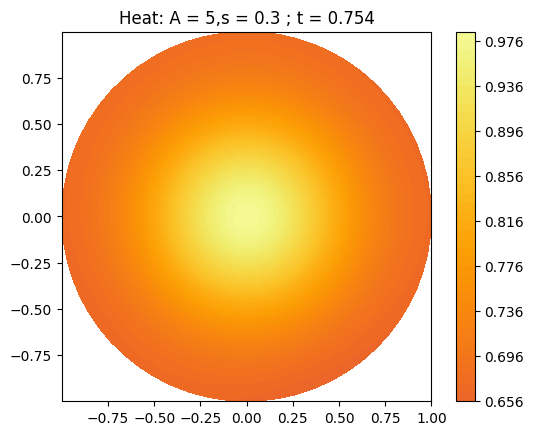

In [152]:
import matplotlib.tri as mtri
triang = mtri.Triangulation(points[:,0], points[:,1], triangles)

N = 150

fig, ax = plt.subplots()

U0 = evaluate(t_vals[N])

contour = ax.tricontourf(
    triang, U0,
    levels=50,
    vmin=0, vmax=1,
    cmap="inferno"
)

plt.colorbar(contour)
ax.set_aspect("equal")
ax.set_title(f"Heat: A = {A},s = {s} ; t = {t_vals[N]:.3f}")

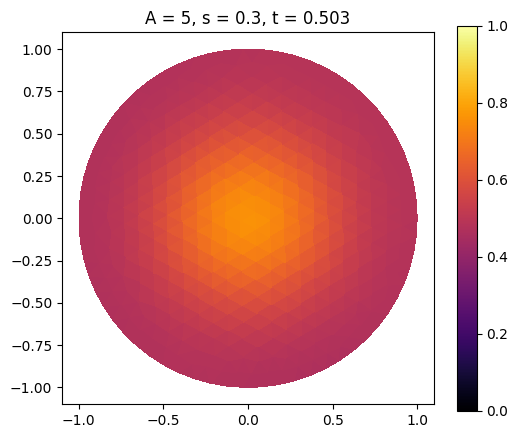

In [164]:
# First frame
fig, ax = plt.subplots(figsize = (6,5))

triang = mtri.Triangulation(points[:,0], points[:,1], triangles)

n = 100

U0 = evaluate(t_vals[n])

tpc = ax.tripcolor(
    triang, U0,
    shading="flat",
    vmin=0, vmax=1,      # colorbar fix
    cmap="inferno"
)

cbar = plt.colorbar(tpc)
ax.set_aspect("equal")
ax.set_title(f"A = {A}, s = {s}, t = {t_vals[n]:.3f}")

plt.savefig(f'HM_{A}_{s}_{t_vals[n]}.png')
plt.show()

## Evaluation over a plane

In [122]:
Nt = 100         # Time Axis
Nx = 100          # x axis

t_vals = np.linspace(T0, TF, Nt)
x_vals = np.linspace(-1, 1, Nx)

X, T = np.meshgrid(x_vals, t_vals)

Y = np.zeros_like(T)

# puntos para mandar al modelo
TX_points = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T

u_tx = model.predict(TX_points)

In [126]:
Nt = 100         # Time Axis
Ny = 100          # x axis

t_vals = np.linspace(T0, TF, Nt)
y_vals = np.linspace(-1, 1, Ny)

Y, T = np.meshgrid(y_vals, t_vals)

X = np.zeros_like(T)

# puntos para mandar al modelo
TY_points = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T

u_ty = model.predict(TY_points)

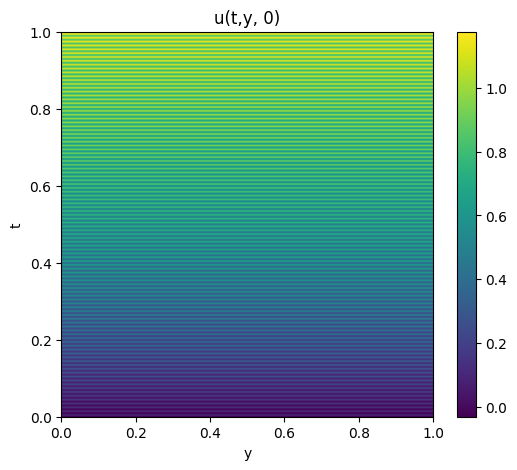

In [138]:
plt.figure(figsize=(6,5))
plt.imshow(u_ty, extent=[0,1,0,1], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('y')
plt.ylabel('t')
plt.title('u(t,y, 0)')


plt.savefig('TY.png')
plt.show()